# 고객 거래 이상징후 탐지

#### 두번째 노트북 필사 : https://www.kaggle.com/shahules/tackling-class-imbalance

* 목표 : 고객별로 거래가 발생했을 때 그에 대한 Fraud의 정도를 예측한다. 
* binary target : isFraud

## Data description
The data is broken into two files **identity** and **transaction**, which are joined by TransactionID.

### transaction table  
It contains money transfer and also other gifting goods and service, like you booked a ticket for others, etc. 

**Features - Transaction**
* TransactionDT: 지정된 거래 참조 날짜의 델타 시간(실제 타임스탬프가 아님)
-> ex) “TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400). So we know the data spans 6 months, as the maximum value is 15811131, which would correspond to day 183."

* TransactionAMT: 거래 결제 금액(USD : 미국달러 단위) 
* dist: 거리 (청구주소, 우편주소, 우편번호, IP주소, 전화 지역간의 거리...) 
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked. 결제 카드와 연결된 주소의 수 등의 counting으로 실제 의미는 숨겨져 있음 
* D1-D15: 이전(previous) 거래 일수와 같은 델타시간
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations. 

**Categorical Features - Transaction**
* ProductCD: 거래별 상품 코드 (여기서 상품은 제품과 더불어 서비스도 포함됨) 
* emaildomain: 구매자 및 수신자 이메일 주소
* card1 - card6:  카드종류(type), 카드분류(category), 발행 은행, 국가 등 결제 지불 카드에 대한 정보 
* addr1, addr2 : 주소(카드 결제한 주소). addr1,2 모두 구매자에 대한 정보로 addr1은 billing region(거래 청구서를 발행한 지역), addr2는 billing country(거래 청구서를 발행한 나라)를 의미한다. 
* P_emaildomain 
* R_emaildomain
* M1-M9: match, such as names on card and address, etc. 카드 이름, 주소 등의 일치(match)

### identity table
이 표의 변수는 identity (ID)에 대한 정보로,(IP, ISP, 프록시 등)와같은 네트워크 연결 정보와 거래와 관련된 전자서명(UA/브라우저/os/버전 등)에 대한 정보를 담고 있습니다. Vesta의 부정 행위 방지 시스템과 디지털 보안 파트너가 이러한 정보를 수집합니다. 
(field명은 maksed 되어 있으며 개인 정보 보호 및 계약 합의를 위해 쌍별 사전이 제공되지 않습니다.)

**Categorical Features - Identity**
* DeviceType : 거래 기기의 유형
* DeviceInfo : 거래 기기에 대한 정보 (연결 네트워크, 전자서명) 
* id_12 - id_38 


### labeling logic
* 부정거래 : Fraud=1
* 합법적 거래 : isFraud = 0  

## Questions
* 1) 어떤 유형의 데이터가 존재하는가
* 2) missing value(누락된 값)은 몇개인가
* 3) target (isFraud) 값의 분포는 어떻게 되는가
* 4) 이상거래와 정상거래의 transactions values의 분포는 어떻게 되는가
* 5) 이상거래가 두드러진 상품이 있는가
* 6) feature나 target이 흥미로운 특징을 보이는가


### 클래스 불균형 해결방안 관련 참고 사이트
https://datascienceschool.net/03%20machine%20learning/14.02%20%EB%B9%84%EB%8C%80%EC%B9%AD%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%AC%B8%EC%A0%9C.html

#### 1. import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix

#### 2. loading train datasets & basic info

In [2]:
train_identity= pd.read_csv("../input/ieee-fraud-detection/train_identity.csv")
train_transactions = pd.read_csv("../input/ieee-fraud-detection/train_transaction.csv")

In [3]:
train_transactions.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [5]:
train_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

#### 3. 클래스 불균형 확인하기

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Target variable count')

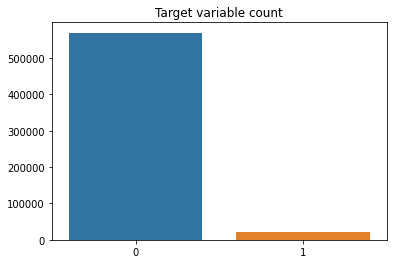

In [6]:
# target variable
# train_transactions['isFraud'].value_counts() # 0:569877개, 1:20663개
x=train_transactions['isFraud'].value_counts().values
sns.barplot([0,1],x)
plt.title('Target variable count')

: **클래스 불균형(class imbalance)**가 존재한다. 

* 클래스 불균형 : 머신러닝 알고리즘은 각 클래스들의 개수가 거의 비슷한 경우에 가장 좋은 결과를 보여준다. 클래스의 개수가 한쪽으로 치우처진 클래스 불균형이 발생한 상황이라면, **'소수의 클래스에 특별히 더 큰 관심이 필요하여'** 클래스 균형을 맞춰야 하는 목적이 있을 때만 그에 맞는 테크닉을 적용하면 된다. 현재 다루고 있는 부정거래를 탐지하는 경우엔 isFraud인 경우(1)가 정상거래(0)보다 훨씬 적다. 그러나 **우리의 관심은 부정거래(1)이기 때문에 정상거래라고 예측하는 정확도에 비해 훨씬 더 큰 정확도를 가져야** 한다. 따라서 클래스 균형을 맞춰주기 위해 'isFraud'인 경우에 더 많은 가중치를 두어야 한다. 

* 참고사이트

https://techblog-history-younghunjo1.tistory.com/74

https://3months.tistory.com/414

https://rosypark.tistory.com/354

* the metric trap (클래스 불균형에서 발생 가능한 모델 평가의 함정)

클래스가 불균형한 경우, accuracy와 같은 평가지표를 사용하면 결과해석에 문제가 발생할 수 있다 (가령 비대칭 데이터셋에서는 정확도가 높아도 재현율[부정거래를 부정거래라고 예측할 확률] 이 급격히 작아지는 현상이 발생한다). 만약 분류기가 피쳐에 대한 분석을 거치지 않고, 단순히 많은 수의 클래스로 예측하게 되면 항상 높은 정확율을 보일 것이다. 

- false positive : 실제로는 부정거래가 아닌데 부정거래라고 판정한 경우
- false negative : 실제로 부정거래인데 정상거래라고 판정한 경우 

* Change the performance metric (클래스 불균형에 적합한 지표)
1. Confusion Matrix
2. precision
3. recall
4. F1 scores

cf) roc 곡선은 각 클래스의 관측수가 거의 동일해야 의미있는 측정지표가 된다. PR(precision-recall) 곡선은 클래스 불균형이 어느정도 많이 두드러질 때 사용한다. 

#### 4. transaction 와 identity dataset 병합하기

In [7]:
train=train_transactions.merge(train_identity,how='left',left_index=True,right_index=True)
y_train=train['isFraud'].astype('uint8') #목표변수셋
print('Train shape',train.shape)

del train_transactions, train_identity


Train shape (590540, 435)


In [8]:
train.head()

,TransactionID_x,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


+) Reducing memory usage (메모리 사용 줄이기) [이해x]

In [9]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

CPU times: user 0 ns, sys: 6 µs, total: 6 µs
Wall time: 10.3 µs


In [10]:
%%time
train = reduce_mem_usage2(train)

Memory usage of dataframe is 1959.88 MB
Memory usage after optimization is: 527.82 MB
Decreased by 73.1%
CPU times: user 37.5 s, sys: 47.4 s, total: 1min 24s
Wall time: 1min 25s


#### 5. splitting to train and validation 훈련 데이터셋,검증 데이터셋으로 나누기 

In [11]:
X_train,X_test,y_train,y_test = train_test_split(train.drop('isFraud',axis=1),y_train,test_size=0.2,random_state=1)

#### 6. resampling

* resampling : 클래스 불균형을 처리하기 위한 기술로, undersampling(다수집단에서 샘플을 제거) 방법과 oversampling(소수 집단에서 더 많은 예를 추가) 방법이 있다. 

* undersampling을 할 때, 줄어든 다수집단의 데이터는 원본 데이터의 대표성을 잘 지니고 있어야 하는 것이 중요하다. oversampling의 경우엔 원본 데이터를 복사하는 개념이기 때문에 양이 늘어난 데이터는 양이 적었던 원본 데이터의 성질과 동일하다. 

##### 6-1. oversmapling 
* 작업할 데이터가 많지 않은 경우 좋은 선택지가 될 수 있다. 

In [12]:
X=pd.concat([X_train,y_train],axis=1)

not_fraud = X[X.isFraud==0]
fraud = X[X.isFraud==1]

# upsample minority
fraud_upsampled = resample(fraud,replace=True,n_samples=len(not_fraud),random_state=27)

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled.isFraud.value_counts()

1    455903
0    455903
Name: isFraud, dtype: int64

Text(0, 0.5, 'count')

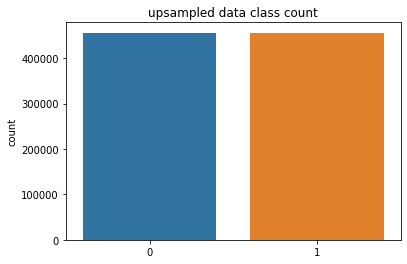

In [13]:
y=upsampled.isFraud.value_counts()
sns.barplot(y=y,x=[0,1])
plt.title('upsampled data class count')
plt.ylabel('count')

##### 6-2. undersample majority class
* 데이터가 엄청 많은 경우엔 수백만개의 행을 고려해 언더샘플링을 선택하는 것이 좋다. 그러나 데이터를 제거하는 것이기 때문에 정보의 손실이 발생하여 테스트 세트에 대한 일반화가 제대로 이루어지지 않을 수 있다. 

In [14]:
not_fraud_downsampled=resample(not_fraud,replace=False,n_samples=len(fraud),random_state=27)

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled,fraud])

# checking counts
downsampled.isFraud.value_counts()

1    16529
0    16529
Name: isFraud, dtype: int64

Text(0, 0.5, 'count')

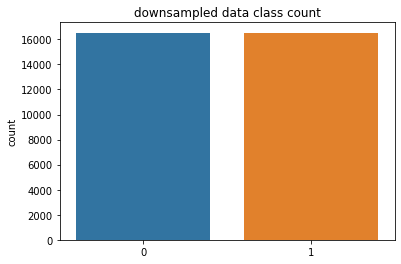

In [15]:
y=downsampled.isFraud.value_counts()
sns.barplot(y=y,x=[0,1])
plt.title('downsampled data class count')
plt.ylabel('count')

#### 7. make_classification 데이터 만들기 
* 사이킷런 패키지는 분류 모형의 테스트를 위해make_classification 와 make_blob 라는 가상 데이터 생성 함수를 제공한다.
* 쉽게 시각화할 수 있도록 make_classification 방법을 사용하여 작은 불균형 샘플 데이터 세트를 생성한다. 

https://taeguu.tistory.com/15

<AxesSubplot:title={'center':'Count(target)'}>

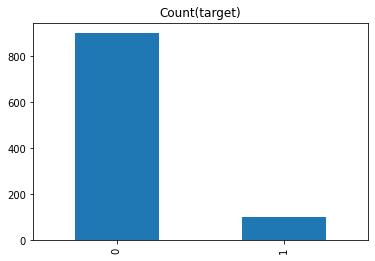

In [18]:
from sklearn.datasets import make_classification


X,y=make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9,0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=1000, random_state=10

)

df=pd.DataFrame(X)
df['target']=y
df.target.value_counts().plot(kind="bar",title='Count(target)')

In [21]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,target
0,0.600131,-1.427664,-0.812843,0.186196,-0.446072,0.961538,-0.108172,-0.121374,-0.064468,-1.331016,...,-0.139450,0.030954,-0.517951,-0.429622,-0.450095,2.303853,-0.553024,0.148770,-1.247959,0
1,0.253641,-1.456387,-0.522598,-1.200570,-0.595553,-1.588192,-0.489398,0.752679,-0.433422,1.552543,...,-0.753243,0.655625,0.612429,-1.190286,0.197738,1.001912,1.694093,-0.249699,0.270857,0
2,0.182256,-1.279602,0.678077,-0.107072,-1.891533,1.219016,0.131442,0.766967,-1.461127,-0.505163,...,0.361457,0.535316,-1.117117,0.500309,-0.062337,-1.664217,-0.811151,-0.287336,-1.234176,0
3,-0.313907,-2.714269,-0.461789,0.451429,0.299209,1.311730,0.320658,-1.460665,-1.075703,0.303755,...,-0.850576,-2.456657,-0.533510,-1.476944,0.430563,-1.735455,-2.002849,1.215284,-0.500204,0
4,-1.262870,0.119181,-1.234628,0.253147,1.551433,1.651135,-0.034720,-0.633148,-1.769543,-0.164800,...,1.080204,-0.765970,-0.633663,-2.961579,1.494173,-2.712421,-0.617613,-1.445949,-1.485457,0


resampling 없이 make_classification으로 생성한 데이터로 로지스틱 회귀분석 모형의 데이터를 적합 및 예측하고 출력 점수를 관찰해보기

In [22]:
def logistic(X,y):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)
    lr=LogisticRegression()
    lr.fit(X_train,y_train)
    prob=lr.predict_proba(X_test)
    return (prob[:,1],y_test)

In [23]:
probs,y_test=logistic(X,y)

PR curve와 roc curve를 그리기 위한 함수 정의하기

In [24]:
def plot_pre_curve(y_test,probs):
    precision, recall, thresholds = precision_recall_curve(y_test,probs)
    plt.plot([0,1],[0.5,0.5],linestyle='--')
    plt.plot(recall,precision,marker='.')
    plt.title("precision recall curve")
    plt.xlabel('Recall')
    plt.ylabel('precision')
    plt.show()

def plot_roc(y_test,prob):
    fpr,tpr,thresholds = roc_curve(y_test,probs)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.plot(fpr,tpr,marker='.')
    plt.title('ROC curve')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rage')
    plt.show()

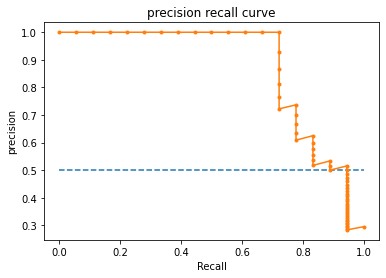

In [25]:
plot_pre_curve(y_test,probs)

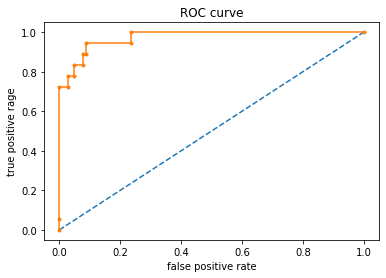

In [26]:
plot_roc(y_test,probs)

 데이터 분포를 확인하기 위해 2차원 플롯함수 plot_2d_space 만들기 

In [34]:
def plot_2d_space(X_train, y_train,X=X,y=y ,label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    
    fig,(ax1,ax2)=plt.subplots(1,2, figsize=(8,4))
   
    for l, c, m in zip(np.unique(y), colors, markers):
        ax1.scatter(
            X_train[y_train==l, 0],
            X_train[y_train==l, 1],
            c=c, label=l, marker=m
        )
    for l, c, m in zip(np.unique(y), colors, markers):
        ax2.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
   
    ax1.set_title(label)
    ax2.set_title('original data')
    plt.legend(loc='upper right')
    plt.show()

#### 8. 차원축소, 군집화(clustering)

* t-SNE 알고리즘(차원축소 알고리즘)을 이해하기 위해 알아야할 개념 
 - Euclidean Distance
 - Conditional Probability
 - Normal and T-Distribution Plots
 

* 차원축소 알고리즘
 - T-sne
 - PCA
 - Truncated SVD
 

* t-sne 알고리즘
: sne 학습과정에서 가우시안 분포대신 t분포를 사용한다. 
https://m.blog.naver.com/xorrms78/222112752837

* Truncated SVD
: https://ariz1623.tistory.com/219

In [28]:
#  t-sne implementation 
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2,random_state=42).fit_transform(X)
t1=time.time()
print("t-sne took {:.2} s".format(t1-t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2,random_state=42).fit_transform(X)
t1=time.time()
print("PCA took {:.2} s".format(t1-t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

t-sne took 7.2 s
PCA took 0.025 s
Truncated SVD took 0.0045 s


위의 세가지 알고리즘 적용한 결과를 2차원 평면에 시각화한다.

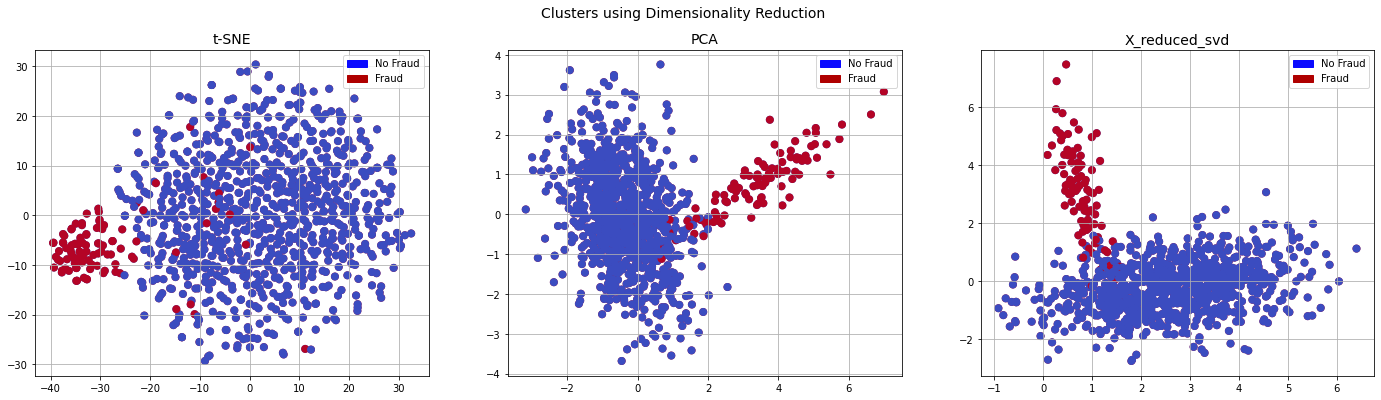

In [29]:
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,6))
# labels=['No Fraud','Fraud']
f.suptitle('Clusters using Dimensionality Reduction',fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-sne scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y==0),cmap='coolwarm',label='No Fraud',linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y==1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y==0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y==1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y==0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y==1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('X_reduced_svd', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

#### 9. 파이썬 imbalanced-learn module 
보다 정교한 resampling 기술이 제안되었다. 예를들어 수가 많은 클래스의 레코드를 클러스터링하고, 각 클러스터에 대해 레코드를 제거하여 undersampling을 수행하여 정보를 보존할 수 있다. oversampling의 경우엔 수가 적은 클래스의 레코드의 정확히 똑같은 복사본을 만드는 대신, 복사본에 작은 변형을 도입하여 다양한 합성 샘플을 만들 수 있다. 파이썬의 imbalanced learn 라이브러리를 통해 구현할 수 있다. 

In [30]:
import imblearn

##### 9-1. random undersampling with imbalanced-learn

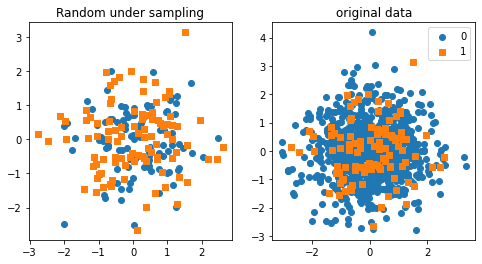

In [36]:
from imblearn.under_sampling import RandomUnderSampler

ran = RandomUnderSampler() #intialize to return indices of dropped rows
X_rs, y_rs = ran.fit_resample(X,y)

## indices : index의 복수
plot_2d_space(X_rs,y_rs,X,y,'Random under sampling')

fit and predict on this data and observe the outcome

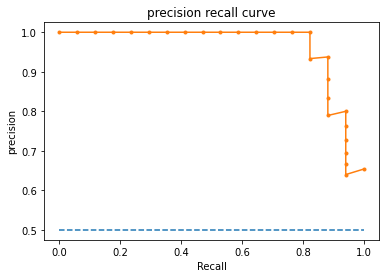

In [37]:
probs, y_test = logistic(X_rs,y_rs)
plot_pre_curve(y_test,probs)

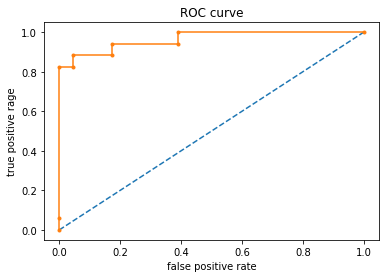

In [38]:
plot_roc(y_test,probs)

##### 9-2. random oversampling with imbalanced-learn

the new data contains 1800 rows


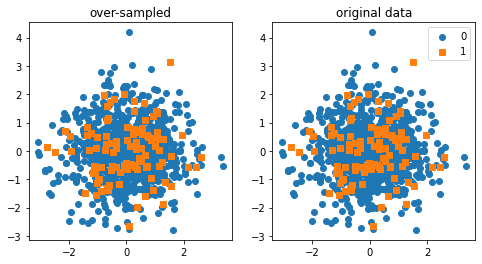

In [39]:
from imblearn.over_sampling import RandomOverSampler

ran=RandomOverSampler()
X_ran, y_ran = ran.fit_resample(X,y)

print('the new data contains {} rows'.format(X_ran.shape[0]))

plot_2d_space(X_ran,y_ran,X,y,'over-sampled')

fit and predict on this data and observe the outcome

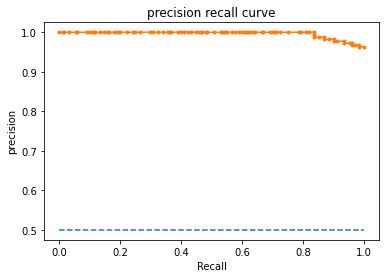

In [40]:
probs,y_test=logistic(X_ran,y_ran)
plot_pre_curve(y_test,probs)

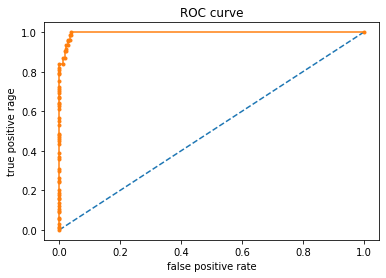

In [41]:
plot_roc(y_test,probs)

#### 10. under-sampling : Tomek links
토멕링크(Tomek’s link)란 서로 다른 클래스에 속하는 한 쌍의 데이터를 뜻한다.이러한 가까운 한 쌍의 데이터를 찾은 다음 그 중에서 다수 클래스(majority class)에 속하는 데이터를 제거하는 방법이다. 이렇게 다수 클래스를 제거함으로써 데이터 불균형 문제도 어느정도 해결이되면서 동시에 두 클래스간의 거리가 멀어지기 때문에 분류 문제를 조금 더 수월하게 만들어 준다. 하지만 여전히 데이터 손실에 대한 문제를 가지고 있기 때문에 유의해야 한다.

https://seing.tistory.com/53

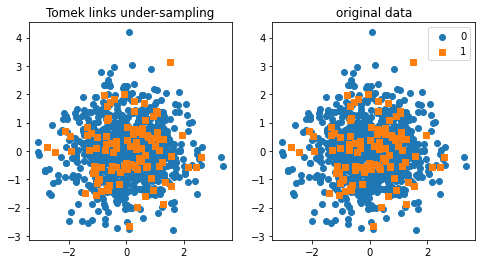

In [47]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks()

X_tl, y_tl = tl.fit_resample(X,y)

plot_2d_space(X_tl, y_tl,X,y, 'Tomek links under-sampling')

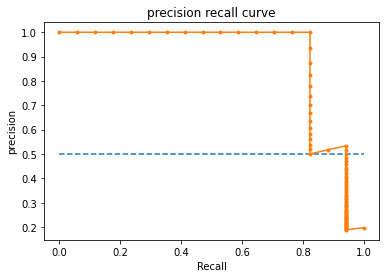

In [48]:
probs,y_test=logistic(X_tl,y_tl)
plot_pre_curve(y_test,probs)

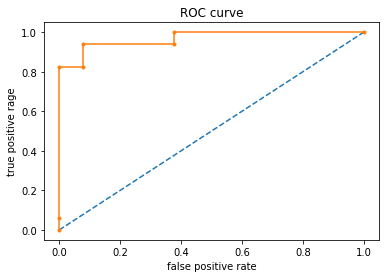

In [49]:
plot_roc(y_test,probs)

#### 11. over-sampling : SMOTE

쉽게 설명하면, SMOTE는 k-nearest neighbour를 활용하여 소수 클래스(minority class)의 임의의 knn 데이터들을 추가하는 방법이다. 기존의 minority class 데이터들 사이를 보간하여 새로운 데이터를 추가하는 것이기 때문에 완전히 새로운 사례의 데이터의 예측에서는 취약할 수 있다.

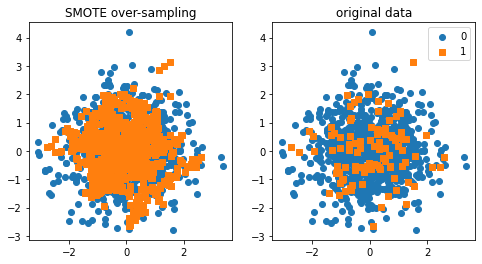

In [50]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X, y)

plot_2d_space(X_sm, y_sm,X,y, 'SMOTE over-sampling')

 fit and predict on this data and observe the outcome.

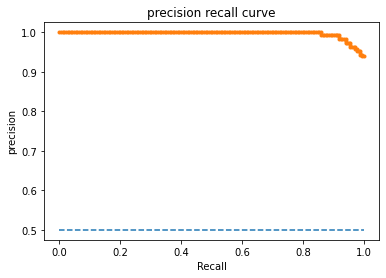

In [51]:
probs,y_test=logistic(X_sm,y_sm)
plot_pre_curve(y_test,probs)

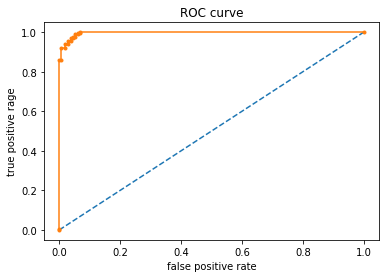

In [52]:
plot_roc(y_test,probs)

##### PR plot
Precision Recall Plot (이하 PR 그래프)의 경우도 ROC 와 유사한데, 주로 데이타 라벨의 분포가 심하게 불균등 할때 사용한데, 예를 들어 이상 거래 검출 시나리오의 경우 정상 거래의 비율이 비정상 거래에 비해서 압도적으로 많기 때문에 (98%, 2%) 이런 경우에는 ROC 그래프보다 PR 그래프가 분석에 더 유리하다. 그래프가 위쪽으로 갈수록 정확도가 높은 모델이고, ROC와 마찬가지로 PR 그래프의 AUC (면적)값을 이용하여 모델의 정확도를 평가할 수 있다. 그러면 모델이 쓸만한 모델인지 아닌지는 어떤 기준을 사용할까? ROC 그래프의 경우에는 Y=X 그래프를 기준으로 그래프 윗쪽에 있는 경우 쓸만한 모델로 판단을 했는데, PR 그래프의 경우 Base line이라는 것을 사용한다.


https://bcho.tistory.com/1206 

#### 12. ensemble algorithm techniques
The above section, deals with handling imbalanced data by resampling original data to provide balanced classes. In this section, we are going to look at an alternate approach i.e. Modifying existing classification algorithms to make them appropriate for imbalanced data sets. 즉 샘플링을 다시하는게 아니라, 분류 알고리즘 자체를 불균형 데이터셋에 맞게 변형해 본다는 것!

The main objective of ensemble methodology is to improve the performance of single classifiers. The approach involves constructing several two stage classifiers from the original data and then aggregate their prediction. 앙상블 방법론의 주요 목표는 단일 분류기의 성능을 개선하는 것이다. 여러 단일 분류기의 결과를 합쳐서 강한 분류기를 만든다. 

* XGBoost (Extreme Gradient Boosting) 
: 일반 Gradient boosting보다 10배 빠른 알고리즘이다. 